In [1]:
from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder \
    .appName("Concatenate CSV Files") \
    .getOrCreate()

# Path to the directory containing all CSV files
csv_directory_path = r"C:\Users\vamsh\OneDrive\Desktop\Healthcare_data\healthcare-data-pipeline\data\03_primary\model_input_table.csv"

# Read all CSV files from the directory into a single DataFrame
combined_df = spark.read.csv(csv_directory_path, header=True, inferSchema=True)

# Show the combined DataFrame
combined_df.show()


+--------------------+-------------------+-------------------+--------------------+--------------------+--------------+--------------------+--------------------+---------------+--------------+---------------------+-------------------+----------------+-----+-----------+---------------+----------------------+---------+--------------+----------+-----------+------------------+--------------+---------------------+------+-------------------+-----------+---------------+---------------+-----------+----------+--------------+-----------+--------------+--------------------+--------------------+------------+-----+----------------+---------+--------+-------------------+-------------------+-------------------+-------------------+-------------+---------+---------+-------------+--------+
|          patient_id|         start_date|          stop_date|        encounter_id|               payer|payer_coverage|        organization|            provider|encounter_class|encounter_code|encounter_description|bas

In [4]:
combined_df.printSchema()


root
 |-- patient_id: string (nullable = true)
 |-- start_date: timestamp (nullable = true)
 |-- stop_date: timestamp (nullable = true)
 |-- encounter_id: string (nullable = true)
 |-- payer: string (nullable = true)
 |-- payer_coverage: double (nullable = true)
 |-- organization: string (nullable = true)
 |-- provider: string (nullable = true)
 |-- encounter_class: string (nullable = true)
 |-- encounter_code: integer (nullable = true)
 |-- encounter_description: string (nullable = true)
 |-- base_encounter_cost: double (nullable = true)
 |-- total_claim_cost: double (nullable = true)
 |-- race: string (nullable = true)
 |-- ethnicity: string (nullable = true)
 |-- medication_code: integer (nullable = true)
 |-- medication_description: string (nullable = true)
 |-- base_cost: double (nullable = true)
 |-- dispense_count: integer (nullable = true)
 |-- total_cost: double (nullable = true)
 |-- reason_code: integer (nullable = true)
 |-- reason_description: string (nullable = true)
 |--

In [6]:
from pyspark.sql.functions import col, sum as _sum

# Calculate the number of null values in each column
null_counts = combined_df.select(
    [( _sum(col(c).isNull().cast("int")).alias(c)) for c in combined_df.columns]
)

# Show the result
null_counts.show()


+----------+----------+---------+------------+-----+--------------+------------+--------+---------------+--------------+---------------------+-------------------+----------------+------+---------+---------------+----------------------+---------+--------------+----------+-----------+------------------+--------------+---------------------+------+----------+------+---------------+---------------+-----------+----------+---------+-----------+--------------+----------+-------+------+------+------+---------+--------+--------+---------+-------------------+-------------------+-------------+---------+---------+-------------+--------+
|patient_id|start_date|stop_date|encounter_id|payer|payer_coverage|organization|provider|encounter_class|encounter_code|encounter_description|base_encounter_cost|total_claim_cost|  race|ethnicity|medication_code|medication_description|base_cost|dispense_count|total_cost|reason_code|reason_description|condition_code|condition_description|gender|birth_date|   ssn|driv

1. How many distinct patients are in the dataset?

In [9]:
# Assuming the dataset has a column named 'patient_id'
distinct_patients = combined_df.select("patient_id").distinct().count()

# Print the result
print(f"Number of distinct patients: {distinct_patients}")


Number of distinct patients: 10000


## There are Total 10,000 distinct patient_ids present

In [21]:
combined_df.select("medication_description").distinct().show(truncate=False)


+------------------------------------------+
|medication_description                    |
+------------------------------------------+
|cyclosporine  modified 100 mg oral capsule|
|prednisone 20 mg oral tablet              |
|cycloSPORINE  modified 100 MG Oral Capsule|
|predniSONE 20 MG Oral Tablet              |
|PREDNISONE 20 MG ORAL TABLET              |
|CYCLOSPORINE  MODIFIED 100 MG ORAL CAPSULE|
+------------------------------------------+



In [22]:
combined_df.select("medication_code").distinct().show(truncate=False)


+---------------+
|medication_code|
+---------------+
|312615         |
|241834         |
+---------------+



In [10]:
combined_df.columns

['patient_id',
 'start_date',
 'stop_date',
 'encounter_id',
 'payer',
 'payer_coverage',
 'organization',
 'provider',
 'encounter_class',
 'encounter_code',
 'encounter_description',
 'base_encounter_cost',
 'total_claim_cost',
 'race',
 'ethnicity',
 'medication_code',
 'medication_description',
 'base_cost',
 'dispense_count',
 'total_cost',
 'reason_code',
 'reason_description',
 'condition_code',
 'condition_description',
 'gender',
 'birth_date',
 'ssn',
 'drivers_license',
 'passport_number',
 'name_prefix',
 'first_name',
 'last_name',
 'maiden_name',
 'marital_status',
 'birthplace',
 'address',
 'city',
 'state',
 'county',
 'fips_code',
 'zip_code',
 'latitude',
 'longitude',
 'healthcare_expenses',
 'healthcare_coverage',
 'annual_income',
 'age_begin',
 'pathology',
 'symptom_count',
 'symptoms']

In [34]:
combined_df.select("symptoms").distinct().show(truncate=False)

+-----------------------------------------+
|symptoms                                 |
+-----------------------------------------+
|Rash:20;Joint Pain:15;Fatigue:23;Fever:18|
|Rash:44;Joint Pain:11;Fatigue:33;Fever:4 |
|Rash:36;Joint Pain:5;Fatigue:44;Fever:11 |
|Rash:47;Joint Pain:29;Fatigue:7;Fever:14 |
|Rash:9;Joint Pain:22;Fatigue:45;Fever:5  |
|Rash:25;Joint Pain:4;Fatigue:30;Fever:3  |
|Rash:2;Joint Pain:43;Fatigue:45;Fever:15 |
|Rash:8;Joint Pain:39;Fatigue:10;Fever:7  |
|Rash:24;Joint Pain:18;Fatigue:34;Fever:13|
|Rash:20;Joint Pain:17;Fatigue:9;Fever:7  |
|Rash:24;Joint Pain:20;Fatigue:31;Fever:8 |
|Rash:34;Joint Pain:46;Fatigue:24;Fever:7 |
|Rash:36;Joint Pain:22;Fatigue:12;Fever:11|
|Rash:0;Joint Pain:4;Fatigue:37;Fever:18  |
|Rash:47;Joint Pain:3;Fatigue:5;Fever:12  |
|Rash:30;Joint Pain:30;Fatigue:41;Fever:19|
|Rash:3;Joint Pain:48;Fatigue:25;Fever:13 |
|Rash:29;Joint Pain:31;Fatigue:23;Fever:8 |
|Rash:35;Joint Pain:47;Fatigue:7;Fever:7  |
|Rash:37;Joint Pain:44;Fatigue:1

In [33]:
combined_df.select("symptom_count").distinct().show(truncate=False)

+-------------+
|symptom_count|
+-------------+
|null         |
|3            |
|4            |
+-------------+



Plot the distinct medications over time using a python plotting library. If you notice any duplicates, go back to your data cleaning section to fix.

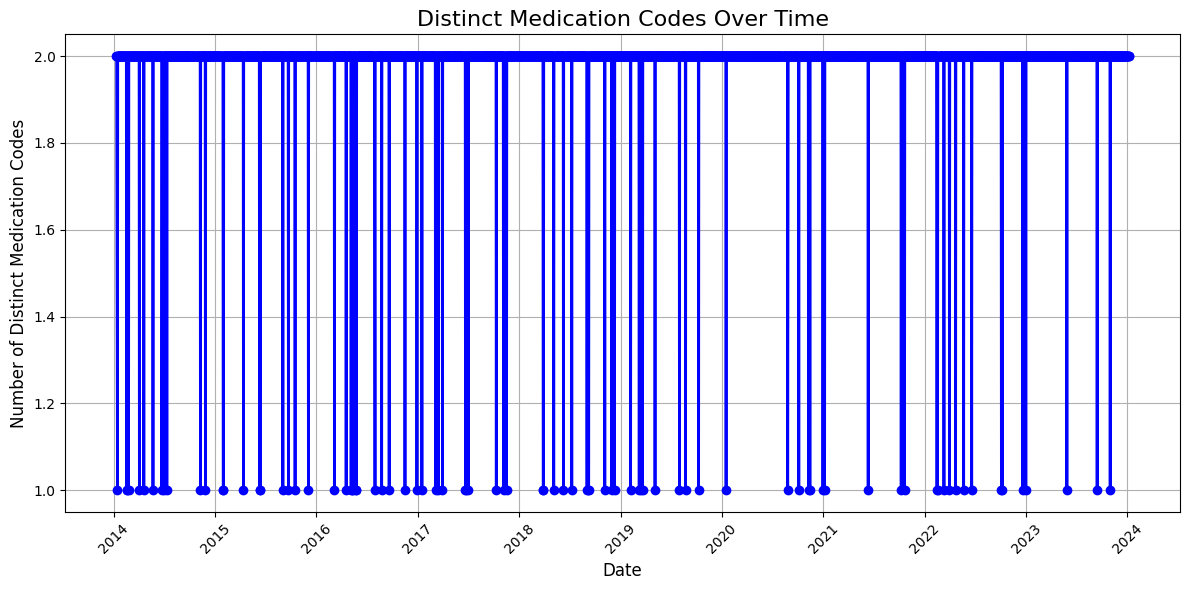

In [25]:
import matplotlib.pyplot as plt
from pyspark.sql import functions as F
from pyspark.sql.functions import to_date

# Convert the 'start_date' to a proper date type (if it's not already)
combined_df = combined_df.withColumn("start_date", to_date("start_date"))

# Remove rows with null values in 'start_date' or 'medication_code'
combined_df = combined_df.filter(combined_df['start_date'].isNotNull() & combined_df['medication_code'].isNotNull())

# Group by date and count distinct medication codes for each day
distinct_medications_per_day = combined_df.groupBy("start_date") \
    .agg(F.countDistinct("medication_code").alias("distinct_medications"))

# Collect the results into a Pandas DataFrame for plotting
medications_df = distinct_medications_per_day.toPandas()

# Sort the DataFrame by start_date to ensure the dates are in order
medications_df = medications_df.sort_values(by='start_date')

# Plot the distinct medications over time
plt.figure(figsize=(12, 6))

# Ensure the plot uses markers and lines, and has proper spacing between points
plt.plot(medications_df['start_date'], medications_df['distinct_medications'], marker='o', color='b', linestyle='-', linewidth=2)

# Add labels and title
plt.title('Distinct Medication Codes Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Distinct Medication Codes', fontsize=12)
plt.grid(True)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Add some padding to the layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


3. Create a piechart indicating the percentage of patients across each racial category and gender.

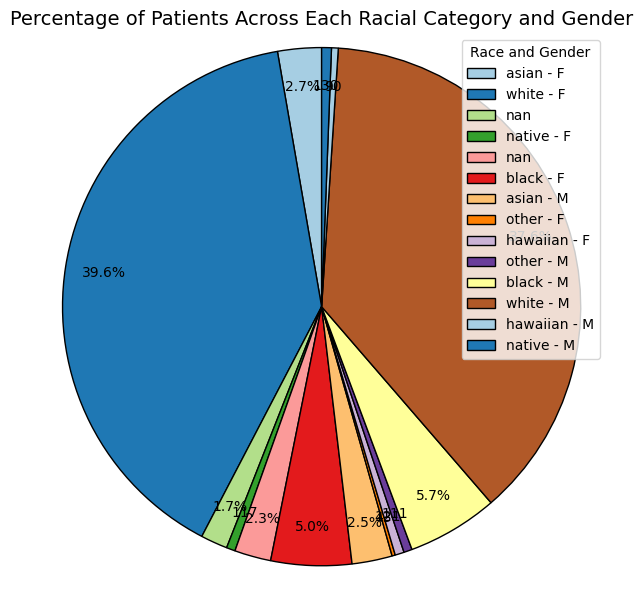

In [40]:
import matplotlib.pyplot as plt
from pyspark.sql import functions as F

# Group by race and gender, and count the number of patients in each group
patients_by_race_gender = combined_df.groupBy("race", "gender").count()

# Collect the results into a Pandas DataFrame for plotting
patients_df = patients_by_race_gender.toPandas()

# Create a new column for combined race and gender labels
patients_df['race_gender'] = patients_df['race'] + ' - ' + patients_df['gender']

# Plotting pie chart
plt.figure(figsize=(6, 6))

# Calculate percentages
total_count = patients_df['count'].sum()
percentages = (patients_df['count'] / total_count) * 100

# Define the autopct function to control percentage label placement
def autopct_func(pct, allvals):
    absolute = round(pct / 100.*sum(allvals), 0)
    return '{:.1f}%'.format(pct) if pct > 1 else f'{absolute:.0f}'

# Plot the pie chart with percentages positioned at the edge of each segment
wedges, texts, autotexts = plt.pie(patients_df['count'], autopct=lambda pct: autopct_func(pct, patients_df['count']), 
                                   startangle=90, colors=plt.cm.Paired.colors, wedgeprops={'edgecolor': 'black'},
                                   pctdistance=0.85, labeldistance=1.05)

# Add title
plt.title('Percentage of Patients Across Each Racial Category and Gender', fontsize=14)

# Add legend to avoid label overlapping
plt.legend(patients_df['race_gender'], title="Race and Gender", loc="best", fontsize=10)

# Adjust the position of the percentage labels to be at the edges of the segments
for autotext in autotexts:
    autotext.set_fontsize(10)
    autotext.set_color('black')

# Show the pie chart
plt.axis('equal')  # Equal aspect ratio ensures that pie chart is drawn as a circle.
plt.tight_layout()
plt.show()


4. What percentage of patients have all 4 symptom categories ≥ 30?

In [39]:
from pyspark.sql import functions as F

# Split the symptoms column into an array of symptom strings
split_symptoms = F.split(combined_df['SYMPTOMS'], ";")

# Extract individual symptom values as integers
rash = F.split(split_symptoms[0], ":")[1].cast("int")
joint_pain = F.split(split_symptoms[1], ":")[1].cast("int")
fatigue = F.split(split_symptoms[2], ":")[1].cast("int")
fever = F.split(split_symptoms[3], ":")[1].cast("int")

# Check if all symptoms are greater than or equal to 30
all_symptoms_ge_30 = (rash >= 30) & (joint_pain >= 30) & (fatigue >= 30) & (fever >= 30)

# Add a column indicating whether all symptoms are >= 30
combined_df = combined_df.withColumn("all_symptoms_ge_30", all_symptoms_ge_30)

# Filter the DataFrame for patients with all symptoms >= 30
filtered_df = combined_df.filter(combined_df["all_symptoms_ge_30"])

# Count the number of patients with all symptoms >= 30
num_patients_all_30 = filtered_df.count()

# Count the total number of patients
total_patients = combined_df.count()

# Calculate the percentage of patients with all 4 symptoms >= 30
percentage = (num_patients_all_30 / total_patients) * 100

# Show the result
print(f"Percentage of patients with all 4 symptom categories >= 30: {percentage:.2f}%")


Percentage of patients with all 4 symptom categories >= 30: 0.00%


Percentage of patients with all 4 symptom categories >= 30: 0.00%